# EDA Analysis  - Rental Listing Enquiries

**Objective:** predict the number of inquiries a new listing receives based on the listing’s creation date and other features in order to:
- Help handle fraud control
- Identify potential listing quality issues
- Allow owners and agents to better understand renters’ needs and preferences. 

Some links of interest:
- https://www.renthop.com/
- https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

Let's load data for the training set and add some usual packages:

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

t_df = pd.read_json("train.json")
print(type(t_df))
print(t_df.shape) # 49,352 obs and 15 vars
print(t_df.columns)

<class 'pandas.core.frame.DataFrame'>
(49352, 15)
Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')


There are 15 parameters: 
- 3 float: Bathrooms, Latitude, Longitude
- 3 int: Bedrooms, listing_id, price 
- 7 str: building_id, created, description, display_address, street_address, interest_level, manager_id, 
- 2 list: features, photos

Preliminary thoughts:
- Interest_level: categorical variable. Response variable (dependent variable). Majority of obs are 'Low interest' thus our algo should primarily be more geared towards correctly identifying this feature to minimize log-loss.
- Display_address and street_address: categorical and unique. These two might be redundant and show multicolinearity.
- Features and Description: word and sentence analysis may render some useful conclusions 
- Interest_level, bedrooms and bathrooms: only variables with small number of unique observations: 3, 9 and 15, respectively    

In [117]:
# variable name, num of unique obs and variable type:
for i in t_df.columns:
    try: 
        print i,'   ', len(list(set(t_df.loc[:,i]))), 'unique obs','               ',str(type(t_df.loc[:,i].iloc[0]))
    except:
        print '=> problems getting unique info: list type'
        next

bathrooms     15 unique obs                 <type 'numpy.float64'>
bedrooms     9 unique obs                 <type 'numpy.int64'>
building_id     7585 unique obs                 <type 'unicode'>
created     48675 unique obs                 <type 'unicode'>
description     38244 unique obs                 <type 'unicode'>
display_address     8826 unique obs                 <type 'unicode'>
features     => problems getting unique info: list type
interest_level     3 unique obs                 <type 'unicode'>
latitude     2335 unique obs                 <type 'numpy.float64'>
listing_id     49352 unique obs                 <type 'numpy.int64'>
longitude     1677 unique obs                 <type 'numpy.float64'>
manager_id     3481 unique obs                 <type 'unicode'>
photos     => problems getting unique info: list type
price     2808 unique obs                 <type 'numpy.int64'>
street_address     15358 unique obs                 <type 'unicode'>


### Response Variable: interest_level

Main takeaways:

- Frequency observations over Total: "Low" interest 69.5%, "Medium" interest 22.8% and "Low" interest 7.8%
- The majority of listings in the training set are classified 'Low' interest. 
- Basically our algo should be particularly good at minimizing misclassification error for the 'low interest' class.

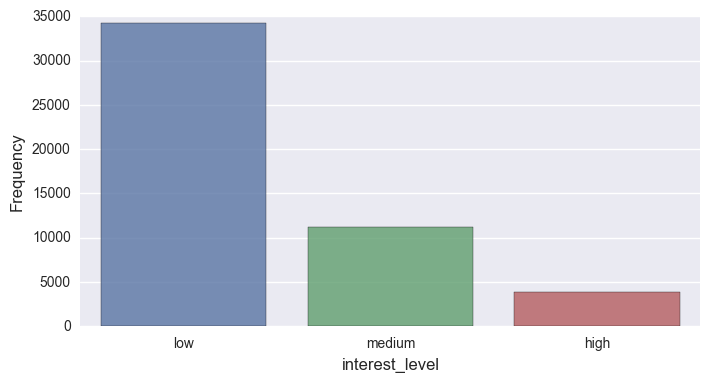

In [17]:
int_level = t_df['interest_level'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('interest_level', fontsize=12)
plt.show()

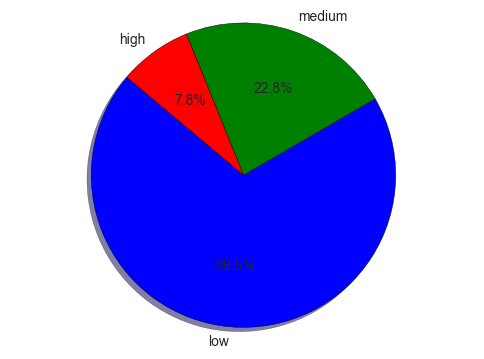

In [19]:
plt.pie(int_level,labels= ['low','medium','high'], autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

### Numerical Variables

A brief statistical summary of all the numerical variables: 

In [20]:
# cont variables analysis
t_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


Preliminary analysis about each parameter/features relationship with the response variable (interest_level):

In [8]:
t_df.groupby('interest_level').describe()

bathrooms      bedrooms      latitude    listing_id  \
interest_level                                                                 
high           count   3839.000000   3839.000000   3839.000000  3.839000e+03   
               mean       1.116176      1.546496     40.748007  7.017844e+06   
               std        0.341725      1.112187      0.051965  1.206596e+05   
               min        0.000000      0.000000     40.575800  6.811957e+06   
               25%        1.000000      1.000000     40.721900  6.913970e+06   
               50%        1.000000      2.000000     40.746500  7.014203e+06   
               75%        1.000000      2.000000     40.773800  7.119334e+06   
               max        4.000000      5.000000     41.086800  7.316287e+06   
low            count  34284.000000  34284.000000  34284.000000  3.428400e+04   
               mean       1.238741      1.514759     40.739504  7.026373e+06   
               std        0.544946      1.111595      0.732933  1.286702e+05   
               min        0.000000      0.000000      0.000000  6.812000e+06   
               25%        1.000000      1.000000     40.729700  6.915616e+06   
               50%        1.000000      1.000000     40.753800  7.024338e+06   
               75%        1.000000      2.000000     40.774725  7.132388e+06   
               max       10.000000      8.000000     44.883500  7.753784e+06   
medium         count  11229.000000  11229.000000  11229.000000  1.122900e+04   
               mean       1.163906      1.622050     40.745567  7.019098e+06   
               std        0.388318      1.122604      0.388466  1.204286e+05   
               min        0.000000      0.000000      0.000000  6.811965e+06   
               25%        1.000000      1.000000     40.726500  6.917736e+06   
               50%        1.000000      2.000000     40.748800  7.013292e+06   
               75%        1.000000      2.000000     40.772400  7.120692e+06   
               max        4.000000      7.000000     44.603800  7.316270e+06   

                         longitude         price  
interest_level                                    
high           count   3839.000000  3.839000e+03  
               mean     -73.964613  2.700293e+03  
               std        0.040286  2.080555e+03  
               min      -74.159800  7.000000e+02  
               25%      -73.990350  1.850000e+03  
               50%      -73.976300  2.400000e+03  
               75%      -73.948600  3.163000e+03  
               max      -73.714200  1.111110e+05  
low            count  34284.000000  3.428400e+04  
               mean     -73.951667  4.176599e+03  
               std        1.355388  2.644932e+04  
               min     -118.271000  4.300000e+01  
               25%      -73.991800  2.625000e+03  
               50%      -73.977900  3.300000e+03  
               75%      -73.956000  4.400000e+03  
               max        0.000000  4.490000e+06  
medium         count  11229.000000  1.122900e+04  
               mean     -73.965033  3.158767e+03  
               std        0.698923  1.243694e+03  
               min      -75.177300  6.950000e+02  
               25%      -73.991800  2.300000e+03  
               50%      -73.978100  2.895000e+03  
               75%      -73.953300  3.650000e+03  
               max        0.000000  1.500000e+04

**Bathrooms:**

- Most listings are showing 1 bathroom
- Violin chart Bathrooms vs Int Level displays same distribution for bathrooms across interest levels
- Number of bathrooms as a continuous variable is not very informative.
- It could make sense to create a categorical variable: "bath+1" = Yes or Not
- There's some outliers in the training sample (max bathrooms 10)
    

In [12]:
t_df.groupby('interest_level').agg(['mean','median','std','max','min'])[['bathrooms']]

bathrooms                            
                    mean median       std   max  min
interest_level                                      
high            1.116176    1.0  0.341725   4.0  0.0
low             1.238741    1.0  0.544946  10.0  0.0
medium          1.163906    1.0  0.388318   4.0  0.0

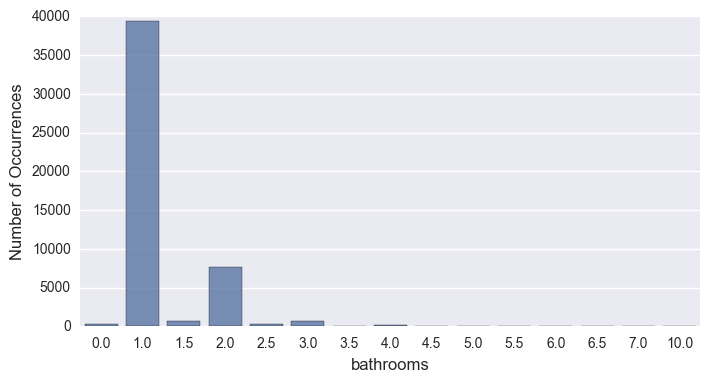

In [4]:
cnt_srs = t_df['bathrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)
plt.show()

C:\Users\Carlo\Anaconda2\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


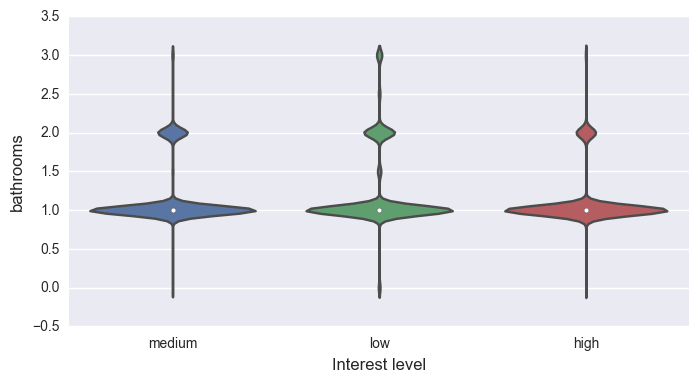

In [5]:
t_df['bathrooms'].ix[t_df['bathrooms']>3] = 3
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bathrooms', data=t_df)
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bathrooms', fontsize=12)
plt.show()

**Bedrooms:**

- More bell-shapped distribution. Probably it could be normalized further using a common transformation method.
- However, histogram by interest level shows that group distributions are less normal when filtering out high interest level
- Apparently, there's no apparent difference between interest_level and number of bedrooms.
- Probably some unsupervised analysis could show some relationships for bathroom, bedrooms and other variables like price.

In [13]:
t_df.groupby('interest_level').agg(['mean','median','std','max','min'])[['bedrooms']]

bedrooms                         
                    mean median       std max min
interest_level                                   
high            1.546496      2  1.112187   5   0
low             1.514759      1  1.111595   8   0
medium          1.622050      2  1.122604   7   0

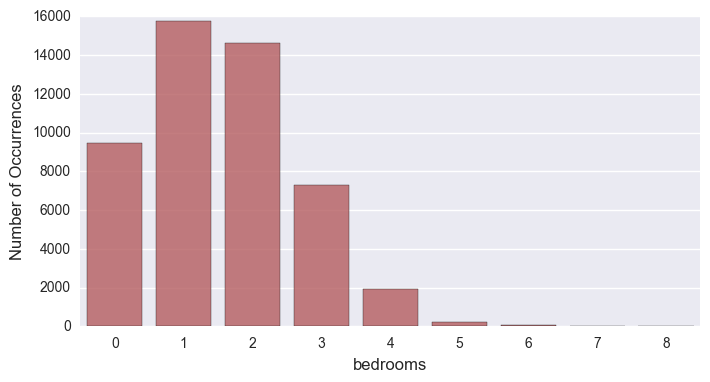

In [6]:
cnt_srs = t_df['bedrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.show()

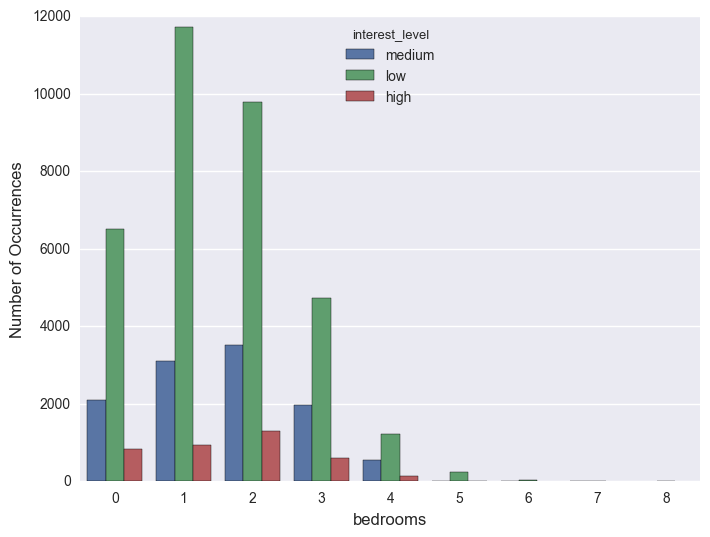

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='bedrooms', hue='interest_level', data=t_df)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.show()


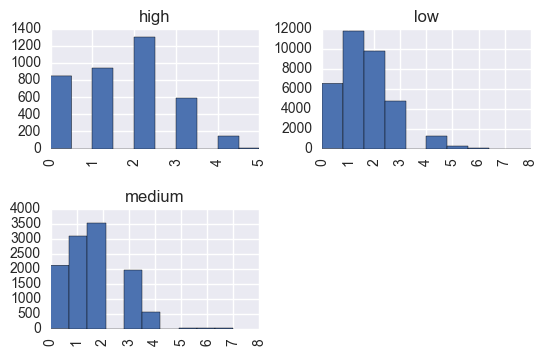

In [20]:
t_df.hist(column="bedrooms", by='interest_level')          
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.show()

**Price:**
- Price frequency distribution seems to be skewed to the right as well as exhibiting significant kurtosis.
- In addition, some outliers in the highest price are creating problems: Removing them should be fine as they are few and not correlated to any other feature.
- Numerical transformations such as log could be an acceptable solution to mitigate extreme values.
- Price seems to be an important variable between interest_levels BUT there's a clear overlapping between interest levels and price levels. 

In [14]:
t_df.groupby('interest_level').agg(['mean','median','std','max','min'])[['price']]

price                                   
                       mean median           std      max  min
interest_level                                                
high            2700.293045   2400   2080.554493   111111  700
low             4176.599142   3300  26449.321541  4490000   43
medium          3158.767388   2895   1243.693692    15000  695

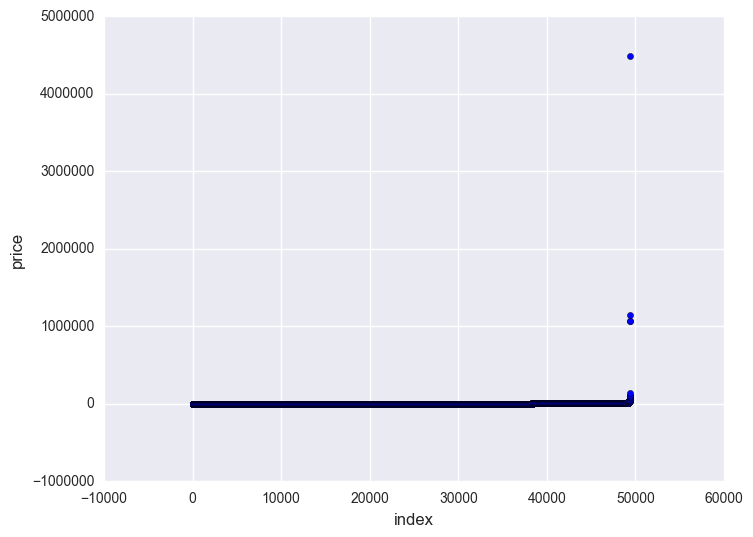

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(range(t_df.shape[0]), np.sort(t_df.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

C:\Users\Carlo\Anaconda2\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


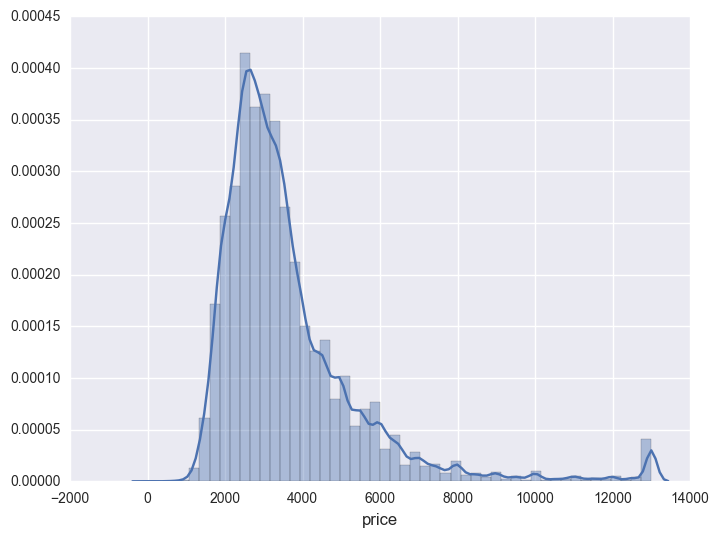

In [2]:
# removing outliers:
ulimit = np.percentile(t_df.price.values, 99)
t_df['price'].ix[t_df['price']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(t_df.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [7]:
p_int_df = t_df.groupby(['interest_level'])['price']
p_int_df.describe()  
################### Median Mean   Range Q3-Q2  ###############
# Total             3,150  3,608  2,500 - 4,100  

# High Interest     2,400  2,674  1,850 - 3,163
# Medium Interest   2,895  3,158  2,300 - 3,650
# Low interest      3,300  3,861  2,625 - 4,400

# Low interest is the variable with highest skew

## 2 new vars:
# 1) Keep 'Price' numerical as it seems there's a significant negative relationship across int_level. Create a new var that 
# reinforces this effect by squaring price.
# 2) 'Low' interest is 70% observations thus it seems (Mean Price + std) threshold could be used to build a new 
# binary var called 'expensive' that will favour 'Low' interest cases 

interest_level       
high            count     3839.000000
                mean      2674.684553
                std       1136.823249
                min        700.000000
                25%       1850.000000
                50%       2400.000000
                75%       3163.000000
                max      13000.000000
low             count    34284.000000
                mean      3861.005979
                std       2011.627642
                min         43.000000
                25%       2625.000000
                50%       3300.000000
                75%       4400.000000
                max      13000.000000
medium          count    11229.000000
                mean      3158.135542
                std       1238.331267
                min        695.000000
                25%       2300.000000
                50%       2895.000000
                75%       3650.000000
                max      13000.000000
Name: price, dtype: float64

**Latitude/Longitude:**
- The latitude values are primarily between 40.6 and 40.9.
- The longitude values range between -73.8 and -74.02. 
- Most of the listings seem to be focused on Manhattan area
- Developed new variables such as "distance_from_midtown", "distance_to_college" and "dist_to_nearest_tube" have resulted in significant relationship with interest levels.

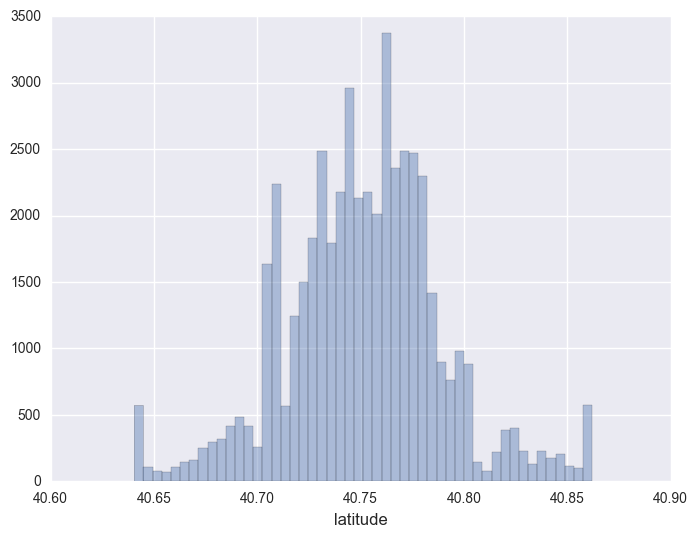

In [30]:
llimit = np.percentile(t_df.latitude.values, 1)
ulimit = np.percentile(t_df.latitude.values, 99)
t_df['latitude'].ix[t_df['latitude']<llimit] = llimit
t_df['latitude'].ix[t_df['latitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(t_df.latitude.values, bins=50, kde=False)
plt.xlabel('latitude', fontsize=12)
plt.show()

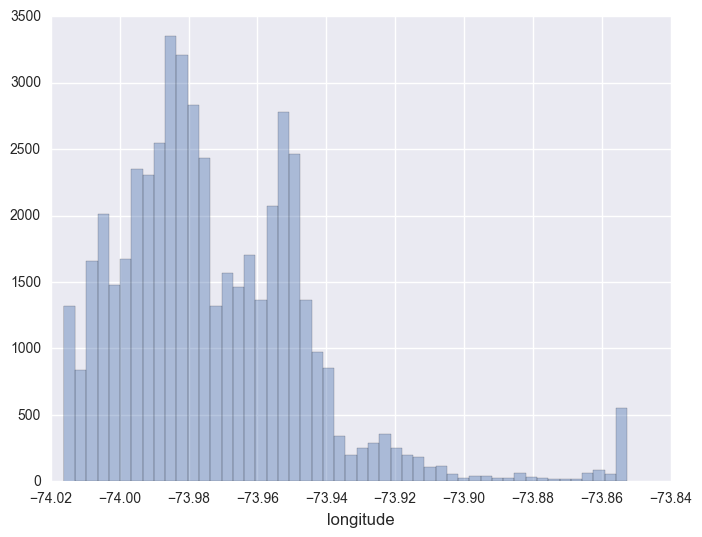

In [31]:
llimit = np.percentile(t_df.longitude.values, 1)
ulimit = np.percentile(t_df.longitude.values, 99)
t_df['longitude'].ix[t_df['longitude']<llimit] = llimit
t_df['longitude'].ix[t_df['longitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(t_df.longitude.values, bins=50, kde=False)
plt.xlabel('longitude', fontsize=12)
plt.show()

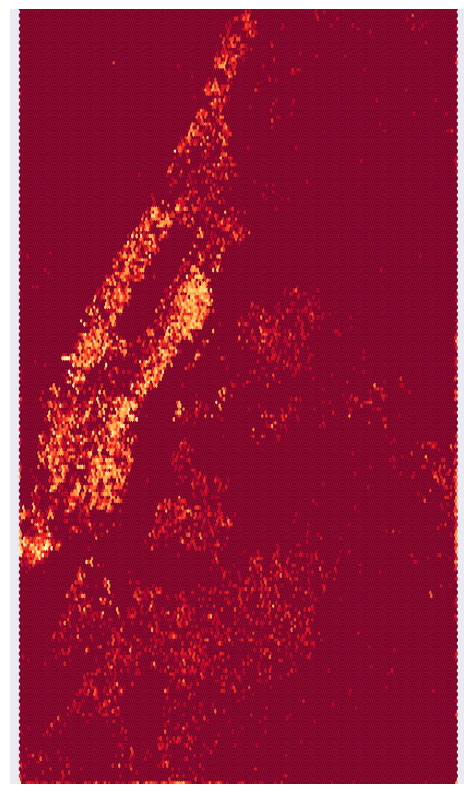

In [33]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

west, south, east, north = -74.02, 40.64, -73.85, 40.86

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='i')
x, y = m(t_df['longitude'].values, t_df['latitude'].values)
m.hexbin(x, y, gridsize=200, bins='log', cmap=cm.YlOrRd_r);

New variables like the ones displayed below (distance to college or distance to nearest tube) are helpful to extract additional value from Latitude and Longitude points. 

In [144]:
Baruch = (40.7402, -73.9834)
Columbia = (40.8075, -73.9626)
Cooper_Union = (40.7299, -73.9903)
FIT = (40.7475, -73.9951)
Hunter_College = (40.7685, -73.9657)
John_Jay = (40.7704, -73.9885)
Julliard = (40.7738, -73.9828)
NYU = (40.7295, -73.9965)
NYU_Tandon = (40.6942, -73.9866)
Pace_University=(40.7111, -74.0049)
Pratt_University = (40.6913, -73.9625)
The_New_School = (40.7355199, -73.99715879999997)
Weill_Cornell = (40.7650, -73.9548) 

schools = [Baruch,Columbia,Cooper_Union,FIT,Hunter_College,John_Jay, Julliard, NYU, NYU_Tandon,
          Pace_University, Pratt_University, The_New_School, Weill_Cornell]
                 
from geopy.distance import vincenty
# https://github.com/geopy/geopy
# calculates vincenty dist
# https://en.wikipedia.org/wiki/Vincenty's_formulae

distance = []
for i in range(0,len(t_df['latitude']),1):
    lat_long = (list(t_df['latitude'])[i],list(t_df['longitude'])[i])
    temp=[]
    for j in schools:
        temp.append(
        vincenty(lat_long, j).meters)
    distance.append(min(temp))

t_df['dist_to_nearest_college'] = distance

In [15]:
# new var: dist_to_nearest_tube
tube_lat_long = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv') \
    [['Station_Name','Station_Latitude','Station_Longitude']]    

tube_lat_long = tube_lat_long.groupby('Station_Name').agg(['mean']) # unique stations only
    
stations=[]
for i,x in enumerate(list(tube_lat_long)):
        stations.append(
            (tube_lat_long.iloc[:,0][i],tube_lat_long.iloc[:,1][i]))
    
from geopy.distance import vincenty
import numpy as np
distance = []
for i,x in enumerate(list(t_df['latitude'])):
    lat_long = (list(t_df['latitude'])[i],list(t_df['longitude'])[i])
    temp=[]
    for j in stations:
        temp.append(
        vincenty(lat_long, j).meters)
    distance.append(min(temp))

t_df['dist_to_nearest_tube']= distance    

The two tables below show how the new variables may add value in predicting models as there's a clear dicotomy between distance metrics and interest levels

In [161]:
t_df.groupby(['interest_level']).agg(['mean','median','std'])[['dist_to_nearest_college']] 

dist_to_nearest_college                            
                                  mean       median            std
interest_level                                                    
high                       2344.018689  1104.296384    2985.540377
low                        4516.056473   923.161169  157177.460797
medium                     2478.881236   989.399185   81869.959015

In [16]:
t_df.groupby(['interest_level']).agg(['mean','median','std'])[['dist_to_nearest_tube']] 

dist_to_nearest_tube                            
                               mean       median            std
interest_level                                                 
high                    6609.702985  6352.830567    3347.485058
low                     9060.190914  5649.306051  156939.590338
medium                  7004.195099  6018.516254   81761.866787

**Created:**
- Time period training set is 04/01/2016 to 29/06/2016.
- Listing creations are higher day 12 and 21 (outliers). 
- On average there are more listing creations during 1st half of the month than second half. 
- 1-7 AM is the favourite time range to create listings (bit weird). 
- Only 3 months available limits analysis about flat renting demand seasonality.

In [36]:
# first create data vars to extract conclusions:
import datetime as datetime
t_df["created"] = pd.to_datetime(t_df["created"])
t_df["created_year"] = t_df["created"].dt.year
t_df["created_month"] = t_df["created"].dt.month
t_df["created_day"] = t_df["created"].dt.day
t_df["created_hour"] = t_df["created"].dt.hour
t_df["created_weekday"] = t_df["created"].dt.weekday

In [29]:
# There's not enough months (only April to June) to analyze seasonal interest_level effects
# the results below show no difference in terms of interest_levels between months
t_df.groupby(['interest_level','created_month']).agg(['mean','median','std'])['bathrooms']

mean  median       std
interest_level created_month                            
high           4              1.113815     1.0  0.336911
               5              1.119125     1.0  0.350517
               6              1.115702     1.0  0.338264
low            4              1.232614     1.0  0.534904
               5              1.249382     1.0  0.555736
               6              1.234855     1.0  0.544351
medium         4              1.165078     1.0  0.391015
               5              1.163874     1.0  0.389121
               6              1.162775     1.0  0.384953

In [31]:
# Week Day Analysis

dft = t_df.groupby(['created_weekday','interest_level']).agg(['count'])['bathrooms']

df_0 = dft.loc[0,:]/dft.loc[0,:].sum()*100
df_1 = dft.loc[1,:]/dft.loc[1,:].sum()*100
df_2 = dft.loc[2,:]/dft.loc[2,:].sum()*100
df_3 = dft.loc[3,:]/dft.loc[3,:].sum()*100
df_4 = dft.loc[4,:]/dft.loc[4,:].sum()*100
df_5 = dft.loc[5,:]/dft.loc[5,:].sum()*100
df_6 = dft.loc[6,:]/dft.loc[6,:].sum()*100

print 0, df_0
print 1, df_1
print 2, df_2
print 3, df_3
print 4, df_4
print 5, df_5
print 6, df_6

0                     count
interest_level           
high             7.973579
low             69.143666
medium          22.882755
1                     count
interest_level           
high             7.508614
low             69.252703
medium          23.238684
2                     count
interest_level           
high             7.669429
low             70.214574
medium          22.115997
3                     count
interest_level           
high             7.773032
low             69.212935
medium          23.014033
4                     count
interest_level           
high             8.547346
low             66.350586
medium          25.102068
5                     count
interest_level           
high             7.334963
low             71.292967
medium          21.372070
6                     count
interest_level           
high             7.729575
low             71.504074
medium          20.766351


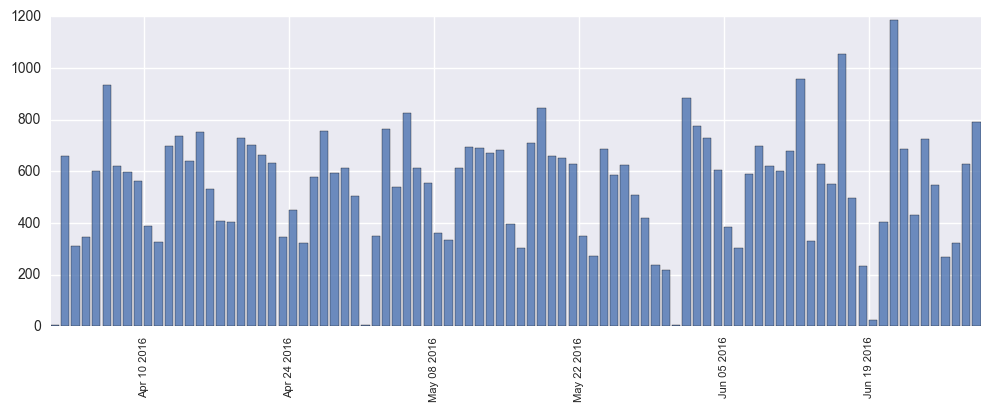

In [4]:
# Training Set time span
t_df["created"] = pd.to_datetime(t_df["created"]) # transform to datetime object
t_df["date_created"] = t_df["created"].dt.date
cnt_srs = t_df['date_created'].value_counts()

plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical', fontsize=8)
plt.show()

Only 3 months are not enough to validate whether or not a seasonal effect exists in interes levels:

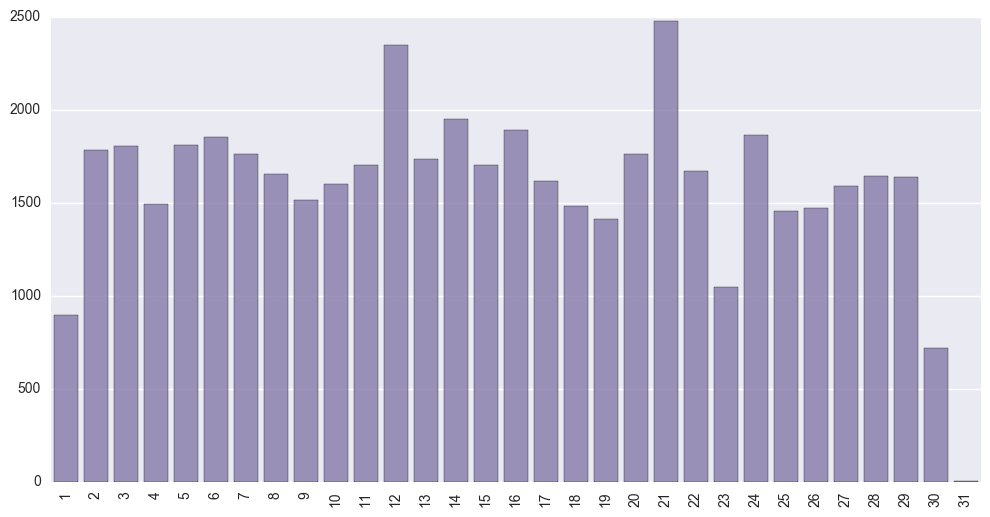

In [32]:
# Calendar Month Day Analysis
cnt_srs = t_df['created_day'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

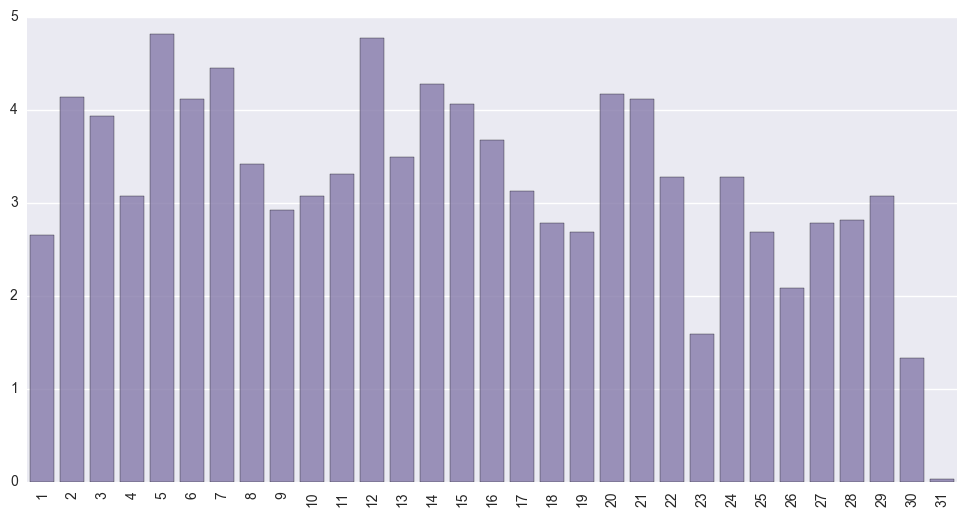

In [34]:
# Checking High interest days: % day X over Total High Interest
df = (t_df.groupby(['created_day','interest_level'],as_index=False)['created_day'].agg(['count']))
df.reset_index(None, inplace=True)
df.set_index('created_day',inplace=True)
df_high_day = df.loc[df.interest_level=='high',:].loc[:,['count']] / sum(df.loc[df.interest_level=='high',:]['count'])*100
# df_high_day measures % Low Interest listings for day X over Total monthly Low Interest listings 
plt.figure(figsize=(12,6))
sns.barplot(list(df_high_day.index), list(df_high_day['count']), alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

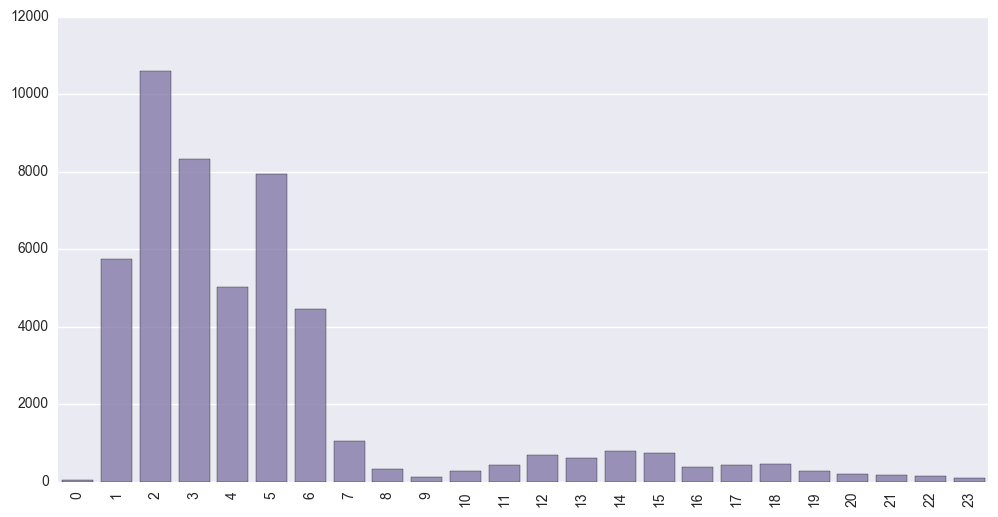

In [37]:
# Time Analysis
cnt_srs = t_df['created_hour'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

### Categorical Variables

**Display Address:**
- Broadway, East 34th, 2nd Avenue and Wall Street are the most frequent listings (+300 each).
- Most of the display addresses occur more than 100 times.
- Only 135 out of 49,352 are empty cells thus not very significant missing values effect.
- Address Style: address style (street, avenue, etc) has no impact on interest level (using new n_type_address variable) so this new variable is redundant and should't be used.
- Broadway vs Top 4 effect: Broadway display_address seems to be significant explaining the spread between the number of low and high interest level. Top 4 display_address classes are slightly relevant thus it's better only to consider the new binary variable **n_broadway**.

In [49]:
df = t_df[['display_address','street_address']]
print df.count()
print 'number of display_address with None:', df.loc[df.display_address== None, 'display_address'].count()
print 'number of display_address empty:', df.loc[df.display_address== '', 'display_address'].count()

display_address    49352
street_address     49352
dtype: int64
number of display_address with None: 0
number of display_address empty: 135


In [52]:
cnt_srs = t_df['display_address'].value_counts()

print 'Top 10 Display Addresses'
print cnt_srs.order(ascending=False).head(10)
print 65*'-'
print 'Bottom 10 Display Addresses'
print cnt_srs.order(ascending=False).tail(10)

Top 10 Display Addresses
Broadway             438
East 34th Street     355
Second Avenue        349
Wall Street          332
West 37th Street     287
West Street          258
First Avenue         244
Gold Street          241
Washington Street    237
York Avenue          228
Name: display_address, dtype: int64
-----------------------------------------------------------------
Bottom 10 Display Addresses
 Second ave             1
143 West 81st Street    1
West 148                1
13th & First Ave.       1
176 Presidents lane     1
Martense St.            1
W 14 STREET             1
620 W 42nd St           1
328 West 77th street    1
56 7th Ave              1
Name: display_address, dtype: int64


C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


Let's create a new variable **n_type_address** to identify listings by type of addresses (street, avenue, etc)

In [56]:
match_list = map(lambda x: re.search('street|st.|st|avenue|ave|ave.|boulevard|blvd|drive|lane|ln|road|rd|place|plc|terrace'
                                     ,x.lower()), list(t_df['display_address']))
type_address=[]
for i in match_list:
    if i== None:
        type_address.append('street')
    elif i.group()== 'avenue' or i.group()== 'ave' or i.group()== 'ave.':
        type_address.append('avenue')
    elif i.group()== 'boulevard' or i.group()== 'blvd':
        type_address.append('boulevard')
    elif i.group()== 'drive':
        type_address.append('drive')    
    elif i.group()== 'lane' or i.group()== 'ln':
        type_address.append('lane')
    elif i.group()== 'road' or i.group()== 'rd':
        type_address.append('road')
    elif i.group()== 'terrace':
        type_address.append('terrace')
    elif i.group()== 'place' or  i.group()== 'plc':
        type_address.append('place')
    else:
        type_address.append('street') # assume is street

t_df['n_type_address']= type_address # new variable starts by n_
da_df = t_df.groupby(['n_type_address','interest_level'])['n_type_address'].agg(['count'])
da_df

count
n_type_address interest_level       
avenue         high              591
               low              4447
               medium           1445
boulevard      high               26
               low               394
               medium            100
drive          high                5
               low                99
               medium             28
lane           high               13
               low               157
               medium             53
place          high               48
               low               400
               medium            144
road           high              208
               low              1290
               medium            531
street         high             2941
               low             27382
               medium           8893
terrace        high                7
               low               115
               medium             35

New Variable **n_type_address** doesn't seem to add value as the interest_level distribution by n_address_type seems to be similar than at an aggregate level:

- "Low" continues to be the interest_level class with highest number of observations.
- "Medium" interest class is normally between 25% and 33% of the observations seen in "Low" interest
- "High" interest class is normally getting 4-5x observations than its respective "Medium" category

These observations are met by all the different n_type_address classes (street, lane, avenue, etc)


Display_address that appear less than 2 times: 63.22%
Display_address that appear less than 10 times: 89.6%
Display_address that appear less than 50 times: 97.73%
Display_address that appear less than 100 times: 99.26%
Display_address that appear less than 500 times: 100.0%


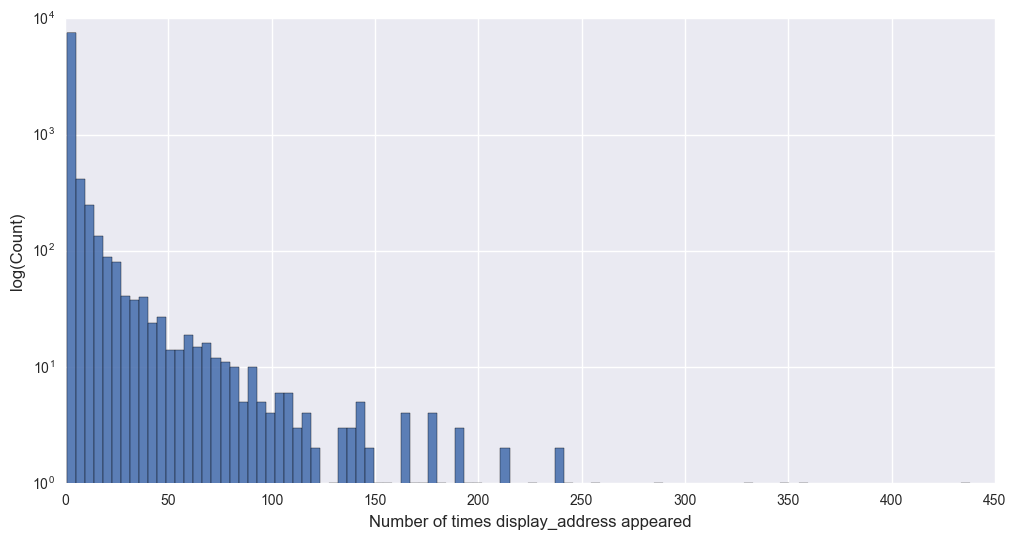

In [29]:
cnt_srs = t_df.groupby('display_address')['display_address'].count()

for i in [2, 10, 50, 100, 500]:
    print('Display_address that appear less than {} times: {}%'.format(i, round((cnt_srs < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_srs.values, bins=100, log=True, alpha=0.9)
plt.xlabel('Number of times display_address appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

**n_broadway** is a significant variable measure by display_address:
- no_bwy class spread between low-high interest is 61.78%
- bwy class spread between low-high interest is 54.22%
- Gap between no_bwy and bwy is then 7.56%.
- Measuring broadway effect using street_address yields worse results so better calculate it using display_adress.


In [134]:
# Broadway effect:
match_list = map(lambda x: re.search('broadway|b?way|b?wy',x.lower()), list(t_df['display_address']))

type_address=[]
for i in match_list:
    if i== None:
        type_address.append(0)
    elif i.group()== 'broadway' or i.group()== 'brwy' or i.group()== 'brway': #second filter
        type_address.append(1)
    else:
        type_address.append(0) 

t_df['n_broadway']= type_address # new variable starts by n_
bwy_df = t_df.groupby(['n_broadway','interest_level'])['n_broadway'].agg(['count'])
# No broadway:
no_bwy = bwy_df.loc[0,:]
no_bwy['%'] = np.round(100* no_bwy/no_bwy.sum(),2)
# Broadway:
bwy = bwy_df.loc[1,:]
bwy['%'] = np.round(100* bwy/bwy.sum(),2)
print 'No Broadway'
print no_bwy
print 65*'-'
print 'Broadway'
print bwy 
# No_bwy low-high difference is 61.78% vs 54.22% => 7.56% difference in Low-High range between No_Broadway and Broadway  

No Broadway
                count      %
interest_level              
high             3783   7.75
low             33926  69.53
medium          11086  22.72
-----------------------------------------------------------------
Broadway
                count      %
interest_level              
high               56  10.05
low               358  64.27
medium            143  25.67


In [131]:
# Top 4 effect:
match_list = map(lambda x: re.search('broadway|b?way|b?wy|west 37th|water street|washington street',x.lower()), list(t_df['display_address']))

top_list=[]
for i in match_list:
    if i== None:
        top_list.append(0)
    else:
        top_list.append(1) 

t_df['n_top_4']= top_list # new variable starts by n_
top_df = t_df.groupby(['n_top_4','interest_level'])['n_top_4'].agg(['count'])
# No Top4:
no_top = top_df.loc[0,:]
no_top['%'] = np.round(100* no_top/no_top.sum(),2)
# Broadway:
top = top_df.loc[1,:]
top['%'] = np.round(100* top/top.sum(),2)
print 'No Top'
print no_top
print 65*'-'
print 'Top'
print top 
# No_Top low-high difference is 61.86% vs 56.80% => 5.06% difference in Low-High range between no_top and top
# This is lower than 7.5% difference found using Broadway_effect thus better use the latter.

No Top
                count      %
interest_level              
high             3693   7.73
low             33232  69.59
medium          10832  22.68
-----------------------------------------------------------------
Top
                count      %
interest_level              
high              146   9.15
low              1052  65.96
medium            397  24.89


**Street Address:**
- 8,826 unique display_address obs vs 15,358 unique street_addresses obs.
- Broadway, West 37th, Water Street and Washington Street are the most frequent listings.
- Broadway ranks first and is the only top address that repeats itself in both display_address and street_address. 
- Only 10 street_address observations out of 49,352 are empty thus the missing values bias here is meaningless.
- Adddress type analysis with street_address yields the same results as with display_address: type of the address has no relationship with interest level.
- Broadway effect: meaningful but less significant than when using display_address variable.


In [51]:
df = t_df[['display_address','street_address']]
print df.count()
print 'number of street_address with None:', df.loc[df.street_address== None, 'street_address'].count()
print 'number of street_address empty:', df.loc[df.street_address== '', 'street_address'].count()


display_address    49352
street_address     49352
dtype: int64
number of street_address with None: 0
number of street_address empty: 10


In [53]:
cnt_srs = t_df['street_address'].value_counts()

print 'Top 10 Street Addresses'
print cnt_srs.order(ascending=False).head(10)
print 65*'-'
print 'Bottom 10 Street Addresses',
print cnt_srs.order(ascending=False).tail(10)

Top 10 Street Addresses
3333 Broadway           174
505 West 37th Street    167
200 Water Street        160
90 Washington Street    142
100 Maiden Lane         131
401 East 34th Street    129
2 Gold Street           120
1 West Street           119
100 John Street         115
95 Wall Street          106
Name: street_address, dtype: int64
-----------------------------------------------------------------
Bottom 10 Street Addresses 270 10th Street                     1
133 E 4th St                        1
888 8th avenue                      1
CENTRAL HARLEM SPECTACULAR***as     1
207 West 80th Street                1
171 East 117th Street\r             1
230 E 32 St.                        1
602 West 190th Street               1
620 Union St                        1
101 West 12th Street                1
Name: street_address, dtype: int64


C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\Carlo\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


In [57]:
# perform address_type analysis with street_address variable:
match_list = map(lambda x: re.search('street|st.|st|avenue|ave|ave.|boulevard|blvd|drive|lane|ln|road|rd|place|plc|terrace'
                                     ,x.lower()), list(t_df['street_address']))
type_address=[]
for i in match_list:
    if i== None:
        type_address.append('street')
    elif i.group()== 'avenue' or i.group()== 'ave' or i.group()== 'ave.':
        type_address.append('avenue')
    elif i.group()== 'boulevard' or i.group()== 'blvd':
        type_address.append('boulevard')
    elif i.group()== 'drive':
        type_address.append('drive')    
    elif i.group()== 'lane' or i.group()== 'ln':
        type_address.append('lane')
    elif i.group()== 'road' or i.group()== 'rd':
        type_address.append('road')
    elif i.group()== 'terrace':
        type_address.append('terrace')
    elif i.group()== 'place' or  i.group()== 'plc':
        type_address.append('place')
    else:
        type_address.append('street') # assume is street

t_df['n_type_street_address']= type_address # new variable starts by n_
sa_df = t_df.groupby(['n_type_street_address','interest_level'])['n_type_address'].agg(['count'])
sa_df # same results as when researching n_type_address with display_address variable 

count
n_type_street_address interest_level       
avenue                high              611
                      low              4492
                      medium           1452
boulevard             high               26
                      low               394
                      medium            103
drive                 high                4
                      low                99
                      medium             28
lane                  high               13
                      low               150
                      medium             50
place                 high               48
                      low               403
                      medium            143
road                  high              213
                      low              1316
                      medium            535
street                high             2914
                      low             27311
                      medium           8877
terrace               high               10
                      low               119
                      medium             41

In [133]:
# Broadway effect:
match_list = map(lambda x: re.search('broadway|b?way|b?wy',x.lower()), list(t_df['street_address']))

type_address=[]
for i in match_list:
    if i== None:
        type_address.append(0)
    elif i.group()== 'broadway' or i.group()== 'brwy' or i.group()== 'brway': #second filter
        type_address.append(1)
    else:
        type_address.append(0) 

t_df['n_broadway']= type_address # new variable starts by n_
bwy_df = t_df.groupby(['n_broadway','interest_level'])['n_broadway'].agg(['count'])
# No broadway:
no_bwy = bwy_df.loc[0,:]
no_bwy['%'] = np.round(100* no_bwy/no_bwy.sum(),2)
# Broadway:
bwy = bwy_df.loc[1,:]
bwy['%'] = np.round(100* bwy/bwy.sum(),2)
print 'No Broadway'
print no_bwy
print 65*'-'
print 'Broadway'
print bwy 
# No_bwy low-high difference is 61.76% vs 55.27% => 6.5% difference in Low-High range between No_bwy and by => display_address Broadway effect was higher at 7.5%


No Broadway
                count      %
interest_level              
high             3783   7.75
low             33924  69.51
medium          11095  22.73
-----------------------------------------------------------------
Broadway
                count      %
interest_level              
high               56  10.18
low               360  65.45
medium            134  24.36


In [117]:
# Top 4 effect:
match_list = map(lambda x: re.search('broadway|b?way|b?wy|west 37th|water street|washington street',x.lower()), list(t_df['street_address']))

top_list=[]
for i in match_list:
    if i== None:
        top_list.append(0)
    else:
        top_list.append(1) 

t_df['n_top_4']= top_list # new variable starts by n_
top_df = t_df.groupby(['n_top_4','interest_level'])['n_top_4'].agg(['count'])
# No Top4:
no_top = top_df.loc[0,:]
no_top['%'] = np.round(100* no_top/no_top.sum(),2)
# Broadway:
top = top_df.loc[1,:]
top['%'] = np.round(100* top/top.sum(),2)
print 'No Top'
print no_top
print 65*'-'
print 'Top'
print top 
# No_Top low-high difference is 61.83% vs 57.54% => 4.29% difference in Low-High range 
# This is lower than 6.5% difference found using Broadway_effect thus better use the latter.

No Top
                count      %
interest_level              
high             3694   7.73
low             33227  69.56
medium          10846  22.71
-----------------------------------------------------------------
Top
                count      %
interest_level              
high              145   9.15
low              1057  66.69
medium            383  24.16


4.289999999999999

**Number of Photos:**
- Bell-shapped distribution.
- The average listing displays between 3-8 pictures
- Violin plot shows no significant differences in mean and distribution when comparing interest_level vs num_photos
- The most remarkable fact is the concentration in "low interest_level" for listings with nil pictures 
- New variable: n_no_photo adds value as prospect tenants want to have some visual check before showing interest
- The probability that a listing with "low" interest is higher for those with no pictures (95.2%) than for those with at least one (67.5%)

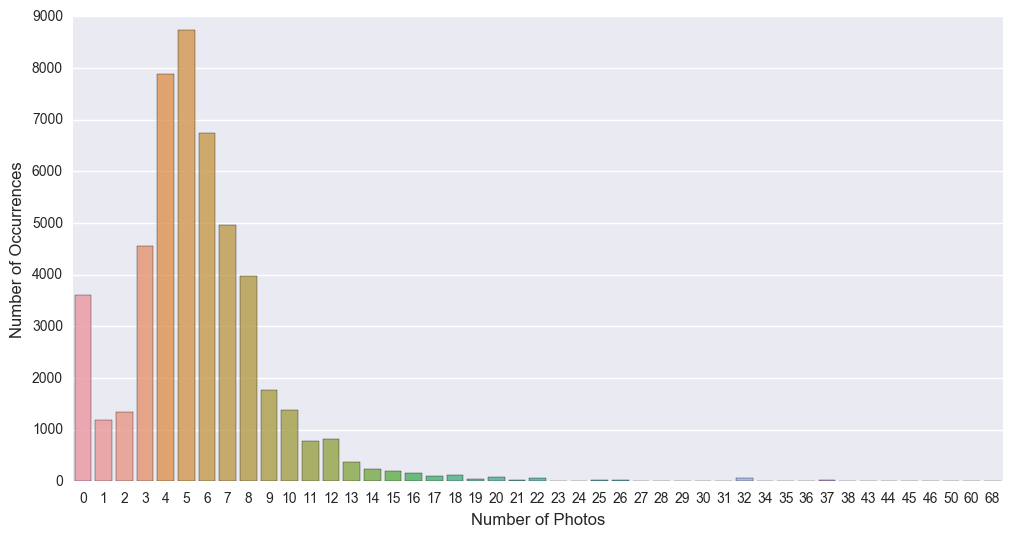

In [86]:
t_df["num_photos"] = t_df["photos"].apply(len) # 'num_photos' are list object remember 
cnt_srs = t_df['num_photos'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

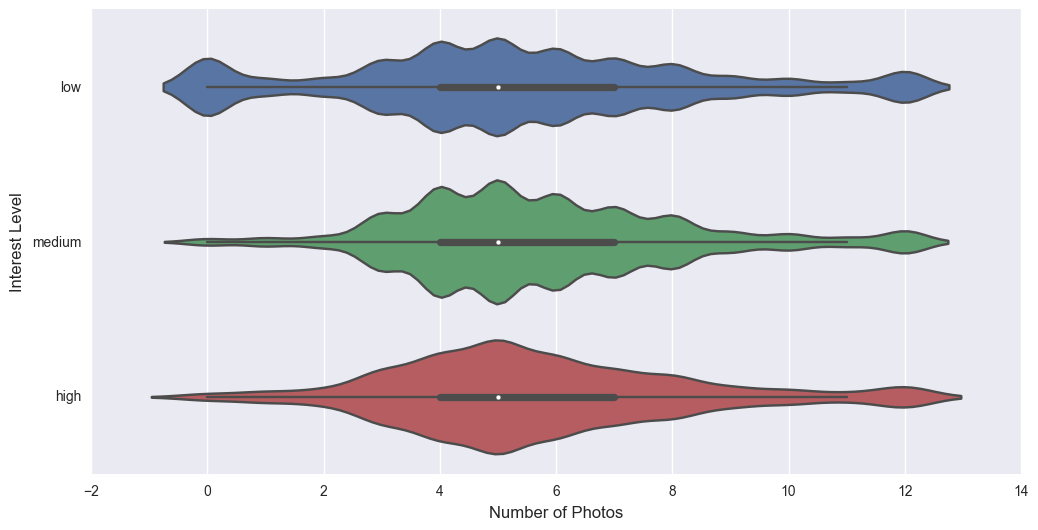

In [88]:
t_df['num_photos'].ix[t_df['num_photos']>12] = 12 # 
plt.figure(figsize=(12,6))
sns.violinplot(x="num_photos", y="interest_level", data=t_df, order =['low','medium','high'])
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Interest Level', fontsize=12)
plt.show()

As the two tables show below, the probability that a listing with "low" interest is higher for those with no pictures (95.2%) than for those with at least one (67.5%)

In [3]:
# new variable: n_no_photo adds value as prospect tenants want to have some visual check before showing interest
t_df['n_no_photo'] = [1 if i == 0 else 0 for i in map(len,t_df['photos'])]

In [4]:
no_photo = t_df.groupby(['n_no_photo','interest_level']).agg('sum')[['listing_id']].iloc[0:3,:]
photo = t_df.groupby(['n_no_photo','interest_level']).agg('sum')[['listing_id']].iloc[3:6,:]
photo/sum(photo['listing_id'])*100

listing_id
n_no_photo interest_level            
1          high              1.379785
           low              95.204469
           medium            3.415746

In [5]:
no_photo/sum(no_photo['listing_id'])*100

listing_id
n_no_photo interest_level            
0          high              8.277528
           low              67.457435
           medium           24.265038

**Number of Features:**
- Feature words look generic across listings so this is great to count words/features. Average listing displays 2-5 features
- However, the Num of features per listing distribution is skewed to the right.
- 'Medium Interest' listings are the ones with a higher average num of features.
- Interestingly low and high interest level listings have similar num of features.
- Measuring number of features importance: n_num_features analysis by interest group classes shows that the number of features per listing is not important so a naive feature count initially would not add value to any model.
- Measuring standalone key word importance: n_key_word new variable measures whether a top ranking word is in a particular listing. Regrettably key words on a standalone basis are not relevant to explain interest level.
- Measuring grouping key word importance: n_num_keyfeat and n_num_keyfeat_score new variables measure whether a top ranking group of words is in particular listing. Luckily there seems to be a strong grouping effect that explains interest level when the  number of key features surpasses 5. In fact, this threshold is significant as there's a certainly linear relationship between interest levels and number of key features for number of key features above this barrier.


In [146]:
df = t_df[['features']]
print df.count()
print 'number of obs with None features:', df.loc[df.features== None, 'features'].count()
print 'number of obs with empty values:', df.loc[df.features== '', 'features'].count()

features    49352
dtype: int64
number of obs with None features: 0
number of obs with empty values: 0


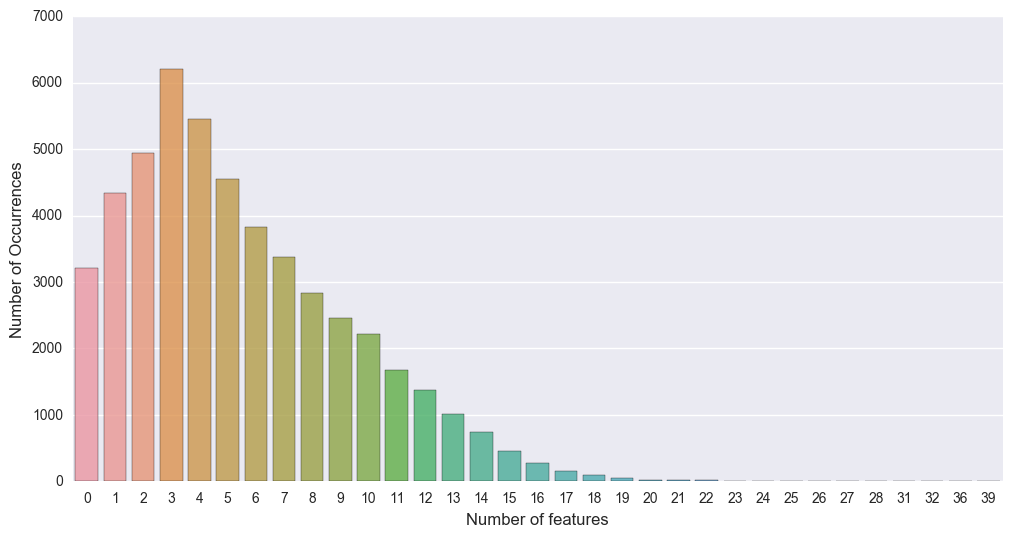

In [97]:
t_df["n_num_features"] = t_df["features"].apply(len) # another list object
cnt_srs = t_df['num_features'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of features', fontsize=12)
plt.show()

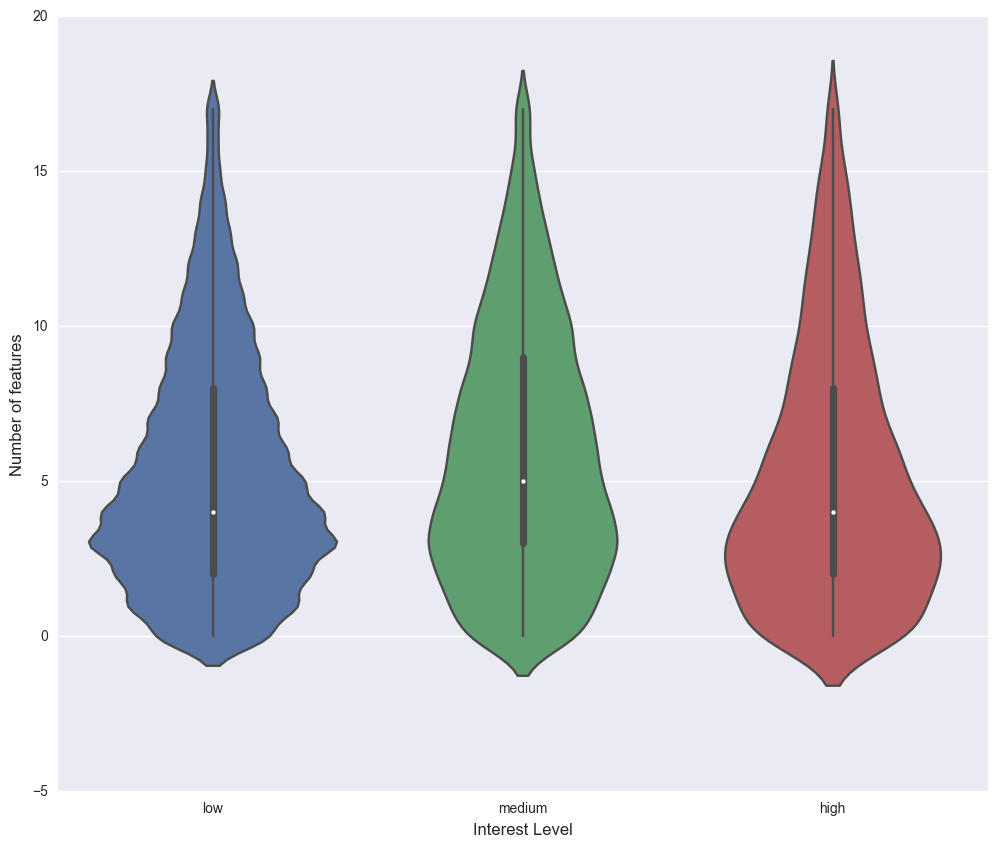

In [100]:
t_df['num_features'].ix[t_df['num_features']>17] = 17
plt.figure(figsize=(12,10))
sns.violinplot(y="num_features", x="interest_level", data=t_df, order =['low','medium','high'])
plt.xlabel('Interest Level', fontsize=12)
plt.ylabel('Number of features', fontsize=12)
plt.show()

Analyzing The number of features relevance below yields a first conclusion: the number of features is not important for listing interest levels. 

In [44]:
#let's check if the num of features matter for interest_level:

t_df["n_num_feat"] = t_df["features"].apply(len) # another list object
nfeat_df = t_df.groupby(['n_num_feat','interest_level'])['n_num_feat'].agg(['count'])

# feat=0 :
feat_0 = nfeat_df.loc[0,:]
feat_0['%'] = np.round(100* feat_0/feat_0.sum(),2)
# feat=5 :
feat_5 = nfeat_df.loc[6,:]
feat_5['%'] = np.round(100* feat_5/feat_5.sum(),2)
# feat=10 :
feat_10 = nfeat_df.loc[11,:]
feat_10['%'] = np.round(100* feat_10/feat_10.sum(),2)
# feat=15 :
feat_15 = nfeat_df.loc[16,:]
feat_15['%'] = np.round(100* feat_15/feat_15.sum(),2)

print 'No Features'
print feat_0
print 65*'-'
print 'Features=5'
print feat_5
print 65*'-'
print 'Features=10'
print feat_10
print 65*'-'
print 'Features=15'
print feat_15
print 65*'-'


No Features
                count      %
interest_level              
high              388  12.06
low              2098  65.20
medium            732  22.75
-----------------------------------------------------------------
Features=5
                count      %
interest_level              
high              285   7.43
low              2652  69.15
medium            898  23.42
-----------------------------------------------------------------
Features=10
                count      %
interest_level              
high              125   7.44
low              1084  64.49
medium            472  28.08
-----------------------------------------------------------------
Features=15
                count      %
interest_level              
high               25   8.83
low               189  66.78
medium             69  24.38
-----------------------------------------------------------------


Most Repeated features: Elevator, Cats/Dogs, Hardwood Floors, Doorman, Dishwasher, No Fee, Laundry, Fitness have more than 13k mentions

In [92]:
feat_lis=[]
for i in np.arange(0,len(t_df['features']),1):
    map(lambda x: feat_lis.append(x),list(t_df['features'])[i])

In [48]:
len(set(feat_lis))# 1556 unique feature expressions 
# most of them are repeated or have similar meaning:
# cats allowed ~ dog allowed ~ Pets allowed
# Doorman = FT Doorman
# Hardwood Flooring = Hardwood Flooring Throughout

1556

In [93]:
pd.DataFrame(pd.Series(feat_lis).value_counts()).iloc[0:50]

,0
Elevator,25915
Cats Allowed,23540
Hardwood Floors,23527
Dogs Allowed,22035
Doorman,20898
Dishwasher,20426
No Fee,18062
Laundry in Building,16344
Fitness Center,13252
Pre-War,9148


In [123]:
lis1=[]
map(lambda x: lis1.append(1) if x!= None else lis1.append(0),['string','string',None])
lis1

[1, 1, 0]

**n_key_word**: boolean variable to check if a key word makes a difference in terms of interest_level. There seems to be no keyword standalone effect on interest_level.

In [101]:
# n_key_word: check if a key word makes a difference in terms of interest_level:

match_list=[map(lambda x: re.search('elevator|cats|dogs|doorman|dishwasher|no fee|laundry|fitness',x.lower()),
                     list(t_df['features'])[i]) for i in np.arange(0,len(t_df['features']),1)]
feat_list =[] 
for i in match_list:
    if i==None:
        feat_list.append(0)
    else:
        if any(i)== False: # check to filter out lists with no all None values
            feat_list.append(0)
        else:
            feat_list.append(1)
feat_list[0:20]

[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]

In [109]:
t_df['n_keyfeat']= feat_list # new variable starts by n_
keyfeat_df = t_df.groupby(['n_keyfeat','interest_level'])['n_keyfeat'].agg(['count'])
# No Top4:
no_key = keyfeat_df.loc[0,:]
no_key['%'] = np.round(100* no_key/no_key.sum(),2)
# Broadway:
key = keyfeat_df.loc[1,:]
key['%'] = np.round(100* key/key.sum(),2)
print 'No Key Feature'
print no_key
print 65*'-'
print 'Key Feature'
print key 
# No_key low-high difference is 56.49% vs 62.5% => 6% difference in Low-High range between No_Key and Key 
# Fundamentally is not sound => makes no sense that listings with a key feature have a higher "low" interest than 
# those without the feature. 2 explanations: 
# i) key features are not as important 
# ii) Only when the features appeared together are important => new analysis

No Key Feature
                count      %
interest_level              
high              707  10.61
low              4472  67.10
medium           1486  22.30
-----------------------------------------------------------------
Key Feature
                count      %
interest_level              
high             3132   7.34
low             29812  69.84
medium           9743  22.82


6.0

**n_num_keyword**: check if the number of key words (groupping effect) per listing makes a difference in terms of interest_level:

In [125]:
# n_num_keyword: check if a key word makes a difference in terms of interest_level:

match_list=[map(lambda x: re.search('elevator|cats|dogs|doorman|dishwasher|no fee|laundry|fitness',x.lower()),
                     list(t_df['features'])[i]) for i in np.arange(0,len(t_df['features']),1)]
nfeat_list =[] 
for i in match_list:
    if i==None:
        nfeat_list.append(0)
    else:
        if any(i)== False: # check to filter out lists with no all None values
            nfeat_list.append(0)
        else:
            lis1=[]
            map(lambda x: lis1.append(1) if x!= None else lis1.append(0),i)            
            nfeat_list.append(sum(lis1))
nfeat_list

[0, 5, 2, 1, 0, 0, 4, 4, 4, 1, 0, 1, 4, 5, 3, 5, 0, 0, 3, 2]

In [133]:
t_df['n_num_keyfeat']= nfeat_list # new variable starts by n_
nkeyfeat_df = t_df.groupby(['n_num_keyfeat','interest_level'])['n_num_keyfeat'].agg(['count'])
# feat=0 :
feat_0 = nkeyfeat_df.loc[0,:]
feat_0['%'] = np.round(100* feat_0/feat_0.sum(),2)
# feat=3 :
feat_3 = nkeyfeat_df.loc[4,:]
feat_3['%'] = np.round(100* feat_3/feat_3.sum(),2)
# feat=5 :
feat_5 = nkeyfeat_df.loc[6,:]
feat_5['%'] = np.round(100* feat_5/feat_5.sum(),2)
# feat=6 :
feat_6 = nkeyfeat_df.loc[7,:]
feat_6['%'] = np.round(100* feat_6/feat_6.sum(),2)
# feat=8 :
feat_8 = nkeyfeat_df.loc[9,:]
feat_8['%'] = np.round(100* feat_8/feat_8.sum(),2)
# feat=10 :
feat_10 = nkeyfeat_df.loc[11,:]
feat_10['%'] = np.round(100* feat_10/feat_10.sum(),2)

print 'No Key Features'
print feat_0
print 65*'-'
print '3 Key Features'
print feat_3
print 65*'-'
print '5 Key Features'
print feat_5
print 65*'-'
print '6 Key Features'
print feat_6
print 65*'-'
print '8 Key Features'
print feat_8
print 65*'-'
print '10 Key Features'
print feat_10
print 65*'-'

# When Num of key features is below 5, there seems to be no effect on % Low interest 
# However there's a fast decline in "low" interest as the num of features rise from 5
# For instance, 0 or 3 key features listings hae around 70% "Low" interest compared to 
# 58% for >7 Key features or 50% "Low" for listings with 10 key features.
# Best thing is that as key features increased above 5, "High" and "Medium" also improve  
# Therefore, we could create a new variable out from num of key features so that:
# 0 for num key features <= 5
# 1 for num key features = 6
# 2 for num key features = 7
# 3 for num key features = 8
# 4 for num key features = 9
# 5 for num key features = 10
# 6 for num key features >= 11

No Key Features
                count      %
interest_level              
high              707  10.61
low              4472  67.10
medium           1486  22.30
-----------------------------------------------------------------
3 Key Features
                count      %
interest_level              
high              422   6.50
low              4757  73.23
medium           1317  20.27
-----------------------------------------------------------------
5 Key Features
                count      %
interest_level              
high              252   5.67
low              3136  70.58
medium           1055  23.75
-----------------------------------------------------------------
6 Key Features
                count      %
interest_level              
high              202   6.12
low              2268  68.66
medium            833  25.22
-----------------------------------------------------------------
8 Key Features
                count      %
interest_level              
high              122 

Below we just create a new variable **n_num_keyfeat_score** to boost **n_num_keyfeat** efficiency by incorporating our threshold at 5:

**n_num_keyfeat_score** incorporates to our grouping key feature analysis a threshold at 5 to account for the effect mentioned in our past analysis.

In [157]:
# new variable n_num_keyfeat_score 
nfeat_score=[]
for i in nfeat_list:
    if i<=5:
        nfeat_score.append(0)
    elif i==6:
        nfeat_score.append(1)
    elif i==7:
        nfeat_score.append(2)
    elif i==8:
        nfeat_score.append(3)
    elif i==9:
        nfeat_score.append(4)
    elif i==10:
        nfeat_score.append(5)
    else:
        nfeat_score.append(6)

t_df['n_num_keyfeat_score']= nfeat_score

The next couple of nested functions create a new variable per each one of the key words in 'features' detected in the rank display earlier:

In [5]:
# TRAIN

def scrub_features(df, method='count'):
    import re
    regex_co = {
        "nofee": "no fee|reduced fee",
        "elevator": "elevator|lift",
        "doorman": "doorman|concierge",
        "fitness": "fitness|swimming|gym",
        "hardwood": "hardwood",
        "dishwash": "dishwasher|appliance|washer|dryer|storage",
        "preWar": "prewar|pre-war",
        "furnished": "furnished",
        "laundry": "laundry",
        "allow_pets": "cats|dogs|pets",
        "internet": "high speed internet|internet|wifi|wi-fi|wireless",
        "adjectives": "exclusive|lowrise|highrise|duplex|wheelchair|new|private|green|renovated|refurbished|light",
        "balcony": "balcony|terrace|garden|patio|outdoor|roof deck|roof-deck|lounge",
        "parking": "parking|garage",
        "subway": "subway|tube"
        

    }

    def create_regex(df, regex, colname, method='count'):
        def find_regex(lis, method=method):
            text = ' '.join(lis)
            r = re.compile(regex, flags=re.IGNORECASE)
            matches = r.findall(text)
            num_matches = len(matches)
            if method == 'count':
                return num_matches
            elif method == 'binary':
                if num_matches > 0:
                    return 1
                else:
                    return 0
        df[colname] = df['features'].apply(find_regex)

    for name, regex in regex_co.items():
        create_regex(df, regex, name, method=method)
    return df
# create key word count variables:
scrub_features(t_df)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,allow_pets,parking,nofee,doorman,balcony,dishwash,elevator,adjectives,subway,fitness
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,0,0,0,0,0,0,0,0,0
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,2,0,0,1,0,0,1,0,0,1
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,1,0,0,0,0,1,0,0,0,0
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,0,0,1,0,0,0,0,0,0,0
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,0,0,0,0,0,0,0,0,0,0
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,...,0,0,0,0,0,0,0,0,0,0
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,...,2,0,1,0,0,0,1,1,0,0
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,...,0,0,0,1,2,1,1,0,0,0
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,...,2,0,0,0,0,0,1,0,0,0
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,...,0,0,0,0,0,1,0,0,0,0


In [21]:
kword_count_df

,nofee,balcony,elevator,subway,laundry,furnished,internet,parking,doorman,dishwash,adjectives,fitness
interest_level,,,,,,,,,,,,
high,1949,1963,1813,24,2306,127,357,103,1134,1626,852,908
low,11203,16106,18300,28,19446,333,2774,1421,15692,14718,5902,11725
medium,5667,6684,6170,61,8007,238,1300,270,4559,5947,2350,3702


In [24]:
kword_count_df = t_df.groupby('interest_level').agg('sum').loc[:,['nofee','balcony','elevator','subway','laundry', 'furnished',
                                                                  'internet','parking','doorman','dishwash','adjectives','fitness']]
pd.DataFrame([100*kword_count_df.iloc[:,i]/sum(kword_count_df.iloc[:,i]) for i in range(0,len(kword_count_df.iloc[1,:]),1)])

interest_level,high,low,medium
nofee,10.356555,59.530262,30.113183
balcony,7.930352,65.066861,27.002788
elevator,6.897995,69.626755,23.475250
subway,21.238938,24.778761,53.982301
laundry,7.748916,65.344938,26.906146
furnished,18.194842,47.707736,34.097421
internet,8.056872,62.604378,29.338750
parking,5.741360,79.208473,15.050167
doorman,5.302782,73.378536,21.318681
dishwash,7.294424,66.026648,26.678929
